In [ ]:
%pip install -qr requirements.txt # install

# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [12]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-256-g5f4b022 Python-3.10.12 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 12044MiB)


Setup complete ✅ (8 CPUs, 15.5 GB RAM, 395.0/437.5 GB disk)


# 1. Detect

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/LNwODJXcvt4'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

In [25]:
!python detect.py --cfg models/yolov5s_quant.yaml --weights experiment_models/yolov5s_quant.pt --img 640 --conf 0.25 --source data/images/zidane.jpg
# display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

detect: weights=['experiment_models/yolov5s_quant.pt'], source=data/images/zidane.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, cfg=models/yolov5s_quant.yaml, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-256-g5f4b022 Python-3.11.5 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 12044MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3521  models.common.QuantConv                 [3, 32, 6, 2, 2, 8, 8]        
  1                -1  1     18561  models.common.QuantConv                 [32, 64, 3, 2, None, 8, 8]    
  2                -1  1     18821  models.com

# 2. Validate
Validate a model's accuracy on the [COCO](https://cocodataset.org/#home) dataset's `val` or `test` splits. Models are downloaded automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases). To show results by class use the `--verbose` flag.

In [ ]:
# Download COCO val
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')  # download (780M - 5000 images)
!unzip -q tmp.zip -d ../datasets && rm tmp.zip  # unzip

In [ ]:
# Validate YOLOv5s on COCO val
!python val.py --weights yolov5s.pt --data coco.yaml --img 640 --half

# 3. Train

In [ ]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --cache

# Train Pretrained

In [ ]:
!python train.py --data coco128.yaml --weights 'yolov5s.pt' --cfg models/yolov5s.yaml --img 416 --epochs 3

# Train QuantModel, not pretrained

In [ ]:
!python train.py --data coco128.yaml --weights '' --cfg models/yolov5s_quant.yaml --img 416 --epochs 3 --classes 80

In [ ]:
ckpt = {}
ckpt['model'] = model.state_dict()
torch.save(ckpt,"experiment_models/yolov5s.pt")

# Train Quantized (QAT)

In [ ]:
# please do not forget to add the --cfg for quant models so the code does not break
!python train.py --img 416 --batch 16 --epochs 3 --data coco128.yaml --cfg models/yolov5s_quant.yaml --weights experiment_models/yolov5s_quant.pt 

# Train PostQuantization (PTQ)

In [17]:
# please do not forget to add the --cfg for quant models so the code does not break
!python train.py --img 416 --batch 16 --epochs 5 --data coco128.yaml --cfg models/yolov5s_quant.yaml --weights yolov5s.pt --device 0

train: weights=yolov5s.pt, cfg=models/yolov5s_quant.yaml, data=coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, classes=80, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-256-g5f4b022 Python-3.11.5 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 12044MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.

  6                -1  3    625161  models.common.QuantC3                   [256, 256, 3, 8, 8]           
  7                -1  1   1180673  models.common.QuantConv                 [256, 512, 3, 2, None, 8, 8]  
  8                -1  1   1182725  models.common.QuantC3                   [512, 512, 1, 8, 8]           
  9                -1  1    656898  models.common.QuantSPPF                 [512, 512, 5, 8, 8]           
 10                -1  1    131585  models.common.QuantConv                 [512, 256, 1, 1, None, 8, 8]  
 11                -1  1         0  brevitas.nn.quant_upsample.QuantUpsample[None, 2, 'nearest']          
 12           [-1, 6]  1         0  models.common.Concat                    [1]                           
 13                -1  1    361989  models.common.QuantC3                   [512, 256, 1, 8, 8, False]    
 14                -1  1     33025  models.common.QuantConv                 [256, 128, 1, 1, None, 8, 8]  
 15                -1  1         0  b

Results saved to runs/train/exp216


# Inference Pretrained Model

In [ ]:
# YOLOv5 PyTorch HUB Inference (DetectionModels only)
import torch

model_pre = torch.hub.load('.',
                       'custom',
                       'experiment_models/yolov5s.pt',
                       source='local',
                       classes = 80,
                       cfg = "models/yolov5s.yaml",
                       force_reload=True
                      )

im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model_pre(im)  # inference
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

In [ ]:
for key,value in model_pre.state_dict().items():
    print(key,value)

# Inference Quantized Model (QAT)

In [24]:
# YOLOv5 PyTorch HUB Inference (DetectionModels only)
import torch

model_p = torch.hub.load('.',
                       'custom',
                       'experiment_models/yolov5s_pre.pt',
                       source='local',
                       classes = 80,
                       cfg = "models/yolov5s.yaml",
                       force_reload=True
                      )

model_q = torch.hub.load('.',
                       'custom',
                       'experiment_models/yolov5s_quant_pre.pt',
                       source='local',
                       classes = 80,
                       cfg = "models/yolov5s_quant.yaml",
                       force_reload=True
                      )

im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model_q(im)  # inference
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

YOLOv5 🚀 v7.0-256-g5f4b022 Python-3.10.12 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 12044MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  mod

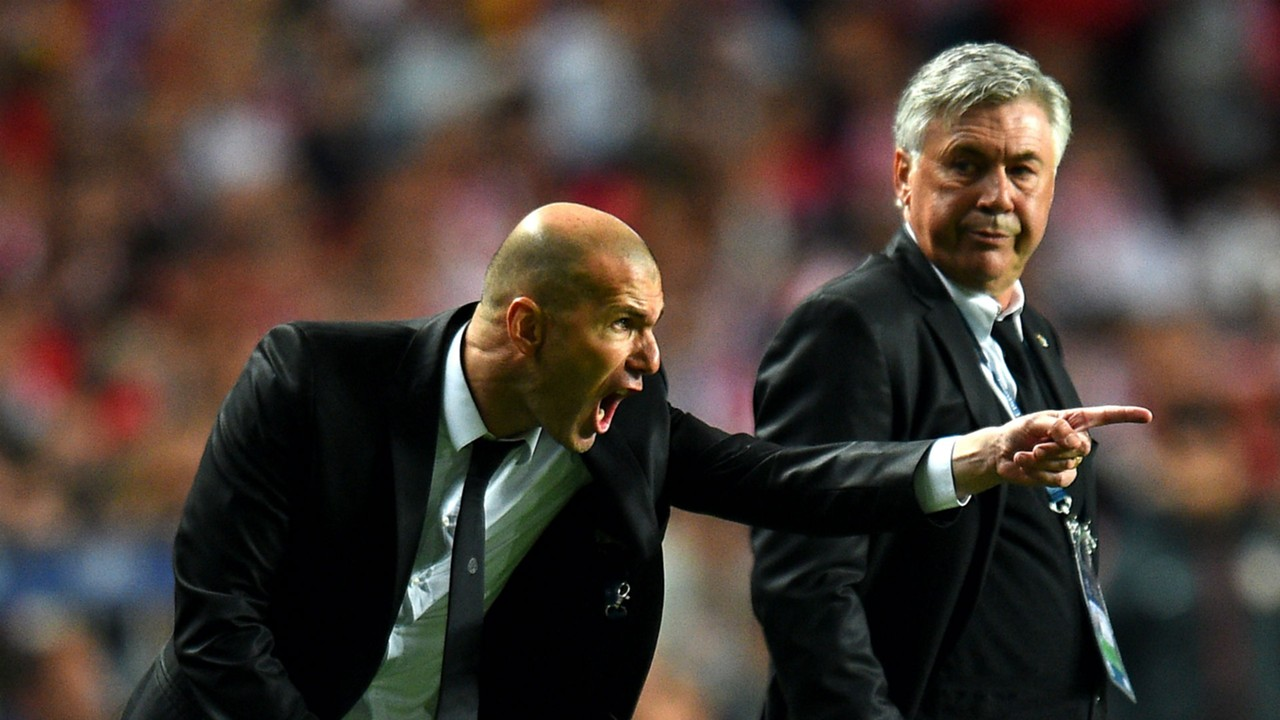

In [4]:
results.show()

# Inference Quantized Model (PTQ)

In [ ]:
# YOLOv5 PyTorch HUB Inference (DetectionModels only)
import torch

model = torch.hub.load('.',
                       'custom',
                       'experiment_models/yolov5s_quant_pre.pt',
                       source='local',
                       classes = 80,
                       cfg = "models/yolov5s_quant.yaml",
                       force_reload=True
                      )

im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model(im)  # inference
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

In [ ]:
df = results.pandas()
df.xyxy

In [ ]:
model_quant(im)

# Copying weights for PTQ

In [ ]:
model.model.model.model[0].conv.weight.data

In [ ]:
model_quant_state = model_quant.state_dict()
model_state = model.state_dict()

for key,value in model_quant_state.items():
    if key in model_state:
        #pass
        #print(key)
        model_quant_state[key] = value
    else:
        print("NotFound",key)
        
#model_quant.load_state_dict(model_quant_state)

In [ ]:
model_quant.model.model.model[0].conv.weight.data

In [ ]:
model_quant.load_state_dict(model.state_dict())

# Save Model

In [19]:
from brevitas.export import export_finn_onnx
import torch

IN_CH = 384
OUT_CH = 640
BATCH_SIZE = 1

path = 'experiment_models/yolov5s_quant.onnx'
inp = torch.randn(BATCH_SIZE,3, IN_CH, OUT_CH).cuda()

detection_model = model_q.model.model
detection_model.cuda()
detection_model.eval()

exported_model = export_finn_onnx(detection_model, inp, path, opset_version=12)

In [21]:
model_q.model.model.model[0].conv.weight

Parameter containing:
tensor([[[[ 3.74569e-03,  1.29232e-01,  1.35577e-01,  2.93213e-01,  1.65933e-01,  1.44947e-01],
          [ 9.63387e-02,  2.50656e-01,  2.85795e-01,  3.87307e-01,  2.50461e-01,  1.71985e-01],
          [ 6.16392e-02,  2.41481e-01,  3.79889e-01,  4.75935e-01,  2.03219e-01,  7.09119e-02],
          [ 8.02822e-02,  1.92873e-01,  2.96141e-01,  3.53925e-01,  5.89550e-02, -4.02875e-02],
          [-1.50023e-01, -7.87693e-02, -4.30205e-02, -1.42263e-02, -2.47338e-01, -3.22886e-01],
          [-2.79353e-01, -2.77791e-01, -3.38113e-01, -2.40895e-01, -3.66028e-01, -3.46312e-01]],

         [[-2.56708e-02,  1.49828e-02, -2.91847e-02,  1.05904e-01,  4.51679e-02,  1.16153e-01],
          [ 9.74124e-02,  1.86918e-01,  1.61638e-01,  2.31330e-01,  1.24645e-01,  1.30404e-01],
          [ 1.14006e-01,  2.29573e-01,  3.02388e-01,  3.49045e-01,  9.16047e-02,  3.55780e-02],
          [ 1.35675e-01,  1.70716e-01,  2.03219e-01,  2.23131e-01, -7.82813e-02, -8.68707e-02],
          [-8.30